# Домашнее задание по теме "Ансамблевые модели"

<pre>
ФИО: Никифоров Владимир
</pre>

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from jupyterthemes import jtplot

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
jtplot.style()

In [2]:
RANDOM_STATE = 7
N_FOLDS = 10

In [3]:
data = pd.read_csv('../data/housing_train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Разбиваем на train/test
d_train, d_test, y_train, y_test = train_test_split(data.drop('SalePrice',axis=1), data.SalePrice, random_state=RANDOM_STATE, test_size=0.2)

In [6]:
d_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1087,1088,60,FV,85.0,10574,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
187,188,50,RL,60.0,10410,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal
671,672,70,RH,54.0,6629,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
652,653,60,RL,70.0,8750,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
1266,1267,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal


In [7]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

# Фильтровать не приходится, т.к. максимальное количество значений - 25
#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
#cat_feat = list(cat_nunique[cat_nunique < 30].index)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         4
CentralAir        2
Electrical        5
KitchenQual       4
Functional        6
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [8]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [9]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,BsmtExposure_Gd,FireplaceQu_TA,MasVnrType_BrkFace,Condition2_PosN,GarageFinish_Unf,Neighborhood_Blmngtn,Condition2_Artery,Exterior1st_Stucco,Utilities_AllPub,Foundation_Slab
1087,60,85.0,10574,8,5,2005,2006,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
187,50,60.0,10410,5,7,1916,1987,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
671,70,54.0,6629,6,6,1925,1950,0.0,551,0,...,0,0,0,0,1,0,0,0,1,0
652,60,70.0,8750,7,5,1996,1996,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
1266,190,60.0,10120,7,4,1910,1950,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0


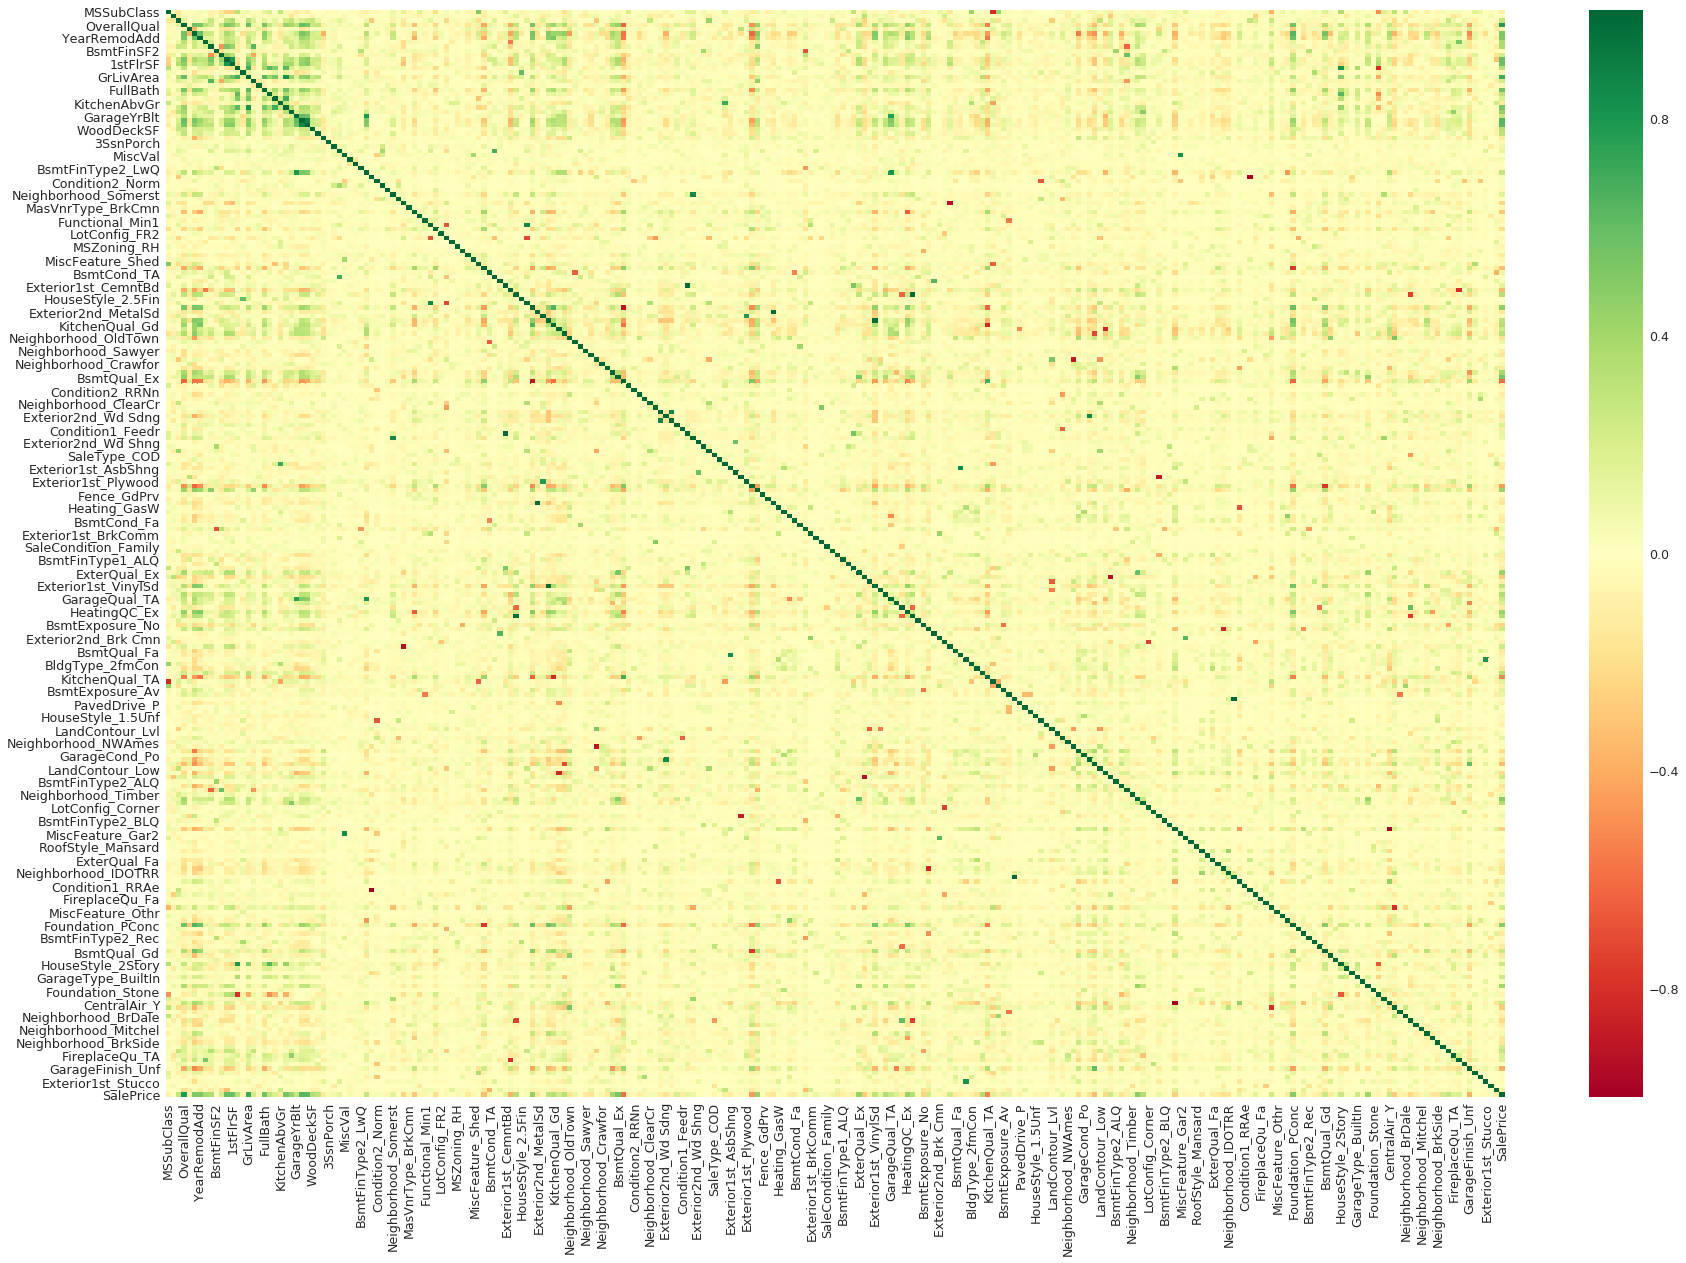

In [10]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(pd.concat([X_train,y_train], axis=1).corr(),annot=False,cmap="RdYlGn");

In [11]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, bootstrap=True, random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=0.8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=7, verbose=0,
                      warm_start=False)

In [12]:
print(f"MSE = {np.mean(-cross_val_score(model_rf,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 2263937014.418716


#### Важность признаков

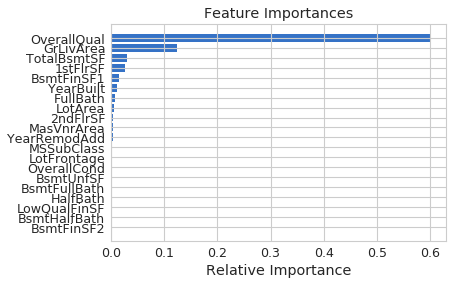

In [13]:
features = X_train.columns
importances = model_rf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Обучим линейную регрессию

In [14]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [15]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_lin, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 4777025491.508918


### Обучим XGBoost

In [17]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
print(model)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      177733.005208     3496.230777   177833.572917    7482.523263
1      161357.484375     3258.888714   161737.458333    7458.183606
2      146696.489583     3071.514813   147286.640625    7242.980367
3      133528.304687     2920.412413   134085.229167    7430.352361
4      121720.861979     2739.877094   122335.679687    7560.687684
5      111161.843750     2579.594051   112093.976563    7536.384492
6      101694.153646     2398.207552   102614.851562    7619.396499
7       93231.403646     2288.828171    94023.328125    7507.131055
8       85633.101562     2222.550812    86495.841146    7630.218097
9       78894.166667     2178.380912    79984.903646    7513.543206
10      72877.994792     2060.286288    74121.364583    7522.521241
11      67497.022135     2013.631342    69074.520834    7449.281800
12      62718.488281     1967.806913    64592.183594    7404.921599
13      58475.941406     1921.062793    60359.06

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=None, n_estimators=360, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [18]:
print(f"MSE = {np.mean(-cross_val_score(model_xgb,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'b

MSE = 1143307117.390828


## Стекинг

Смешаем дерево, линейную регрессию и XGBoost

In [22]:
type(y_test)

pandas.core.series.Series

In [19]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [20]:
from sklearn.model_selection import KFold

stack_cv = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(model_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(model_xgb, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

LR features...
RF features...
XGB features...


/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/truename/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'b

In [21]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью LR

In [22]:
model_lr_meta = LinearRegression(n_jobs=-1)
model_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [23]:
y_pred_meta_test = model_lr_meta.predict(X_meta_test)
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_meta_test,y_pred_meta_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 1.0072536104323507e-20


В результате, использование ансамблей моделей действительно улучшает качество.

In [24]:
y_pred_meta_test

array([153070.94064311, 185489.25796829, 175372.69091033, 106174.62565026,
       125793.33506479, 300097.79456893, 138078.70631804, 125683.26255728,
       148139.12684141, 122996.52586613, 224453.82221151, 169635.16284956,
       114238.78579551, 184896.74731377, 204273.69343653, 167600.86742805,
       218982.22044379, 151182.56940847, 116345.78388948, 187768.20372617,
       194052.96409117, 150240.96903802, 107721.52062392, 229985.92182537,
       346771.78541081, 125939.39782248, 107656.63458183, 173979.41651345,
       219801.67011294, 125803.18415245, 183547.55499547, 194950.99477039,
       324916.64393978, 255794.58389785, 176274.28780801, 301842.10270895,
       134788.77274013, 140463.86633305, 277002.35913561, 197445.29780613,
       116515.03144037, 181405.01829844, 164797.59889088, 139711.1622551 ,
       291493.47447996, 228862.83695193, 187969.50343668, 175338.56112798,
       252429.60632862, 231932.21984056, 267469.46395429, 167889.44705701,
       161487.62712082, 2

#### Посмотрим на коэффициенты объединяющей линейной модели

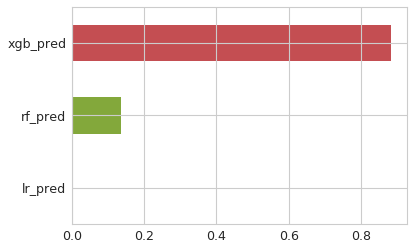

In [25]:
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

XGBoost важнее всех!